## Load The Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from pandas.plotting import parallel_coordinates
import plotly.graph_objs as go
from mpl_toolkits import mplot3d
import plotly.offline as offline

offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')
sns.set_style("white")

## Load the Data

In [2]:
df_forest = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-3/master/Projects/Forestcover_train.csv")

## Check out the Data

In [3]:
df_forest.shape

(15120, 56)

In [4]:
df_forest.dtypes.unique()

array([dtype('int64')], dtype=object)

In [5]:
df_forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

In [6]:
df_forest.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1            220             235            151  ...            0   
2            234             238            135  ...            0   
3            238             238            122  ...            0   
4            220             234            150  ...            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0           5  
1            0            0            0           5  
2            0            0            0           2  
3            0            0            0           2  
4            0            0            0           5  

[5 rows x 56 columns]

#### The dataset given here contains spectral data of 7 different forest covers taken at different times w.r.t different positions of sun and probably a field spectrometer. The features in the dataset contains the cartographic features - Elevation, Aspect, Slope, distance to various already-mapped object like water body, roadways and fire hazard points, type of soil in the ground and the type of wilderness area

#### Our objective is to build a model which can predict the forest cover type so that the GIS mapping for the nearby surfances from either a satellite or a spectrometer or any other GIS mapping device

#### For the entire exercise, we would assume that the surface objects are uniform in shape i.e. they reflect sunlight equally in all the directions, the horizontal or the vertical distances from the nearby points are equal from any point their surface area

| Columns | Decription     | Unit |
|---------|-----------------|------------|
|   Elevation  |Elevation in meters|meters|
| Aspect   |Aspect in degrees azimuth|degrees azimuth|
|Slope    |Slope in degrees|degrees|
|Horizontal_Distance_To_Hydrology|Horz Dist to nearest surface water features|meters|
|Vertical_Distance_To_Hydrology   |Vert Dist to nearest surface water features|meters|
|Horizontal_Distance_To_Roadways     |Horz Dist to nearest roadway|meters|
|Hillshade_9am       |Hillshade index at 9am, summer solstice|0 to 255 index|
|Hillshade_Noon|Hillshade index at noon, summer solstice|0 to 255 index|
|Hillshade_3pm|Hillshade index at 3pm, summer solstice|0 to 255 index|
|Horizontal_Distance_To_Fire_Points|Horz Dist to nearest wildfire ignition points|meters|
|Wilderness_AreaX (4 Binary Features) |Wilderness area designation|binary, 0/1|
|Soil_TypeX (40 Binary Features)|Soil Type designation|binary, 0/1|
|Cover_TypeX (7 Classes)|Forest Cover Type designation|1,2,3,4,5,6,7|

##### Let us group the column names as per their dictionary

In [7]:
actual_features = ['Elevation', 'Aspect', 'Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
                   'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
                   'Horizontal_Distance_To_Fire_Points']
encoded_features_soil_type = ['Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7',
                              'Soil_Type8','Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14',
                              'Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21',
                              'Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26','Soil_Type27','Soil_Type28',
                              'Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35',
                              'Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39','Soil_Type40']
encoded_features_wilderness_area = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3','Wilderness_Area4']
label = 'Cover_Type'

##### Shortening the name of the columns using dictionary comprehension

In [8]:
soil_type_names = []
for x in range(1,41):
    soil_type_names.append("S{}".format(str(x)))
# wilderness_area_names = []
# for x in range(1,5):
#     wilderness_area_names.append("W{}".format(str(x)))

In [9]:
soil_types = {encoded_features_soil_type[i]: list(soil_type_names)[i] for i in range(len(encoded_features_soil_type))}
# wilderness_areas = {encoded_features_wilderness_area[i]: list(wilderness_area_names)[i] for i in range(len(encoded_features_wilderness_area))}

In [10]:
df_forest.rename(columns=soil_types, inplace=True)
#df_forest.rename(columns=wilderness_areas, inplace=True)
df_forest.rename(columns={"Wilderness_Area1":"Rawah","Wilderness_Area2":"Neota","Wilderness_Area3":"Comanche Peak",
                          "Wilderness_Area4":"Cache la Poudre"}, inplace=True)
df_forest.rename(columns={"Horizontal_Distance_To_Hydrology":"HD_Hydro"}, inplace=True)
df_forest.rename(columns={"Vertical_Distance_To_Hydrology":"VD_Hydro"}, inplace=True)
df_forest.rename(columns={"Horizontal_Distance_To_Roadways":"HD_Roads"}, inplace=True)
df_forest.rename(columns={"Horizontal_Distance_To_Fire_Points":"HD_Fire"}, inplace=True)

In [11]:
actual_features = ['Elevation','Aspect','Slope','HD_Hydro','VD_Hydro','HD_Roads','Hillshade_9am','Hillshade_Noon',
                   'Hillshade_3pm','HD_Fire']
encoded_features_soil_type = [ 'S1', 'S2', 'S3', 'S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15','S16','S17',
                              'S18','S19','S20','S21','S22','S23','S24','S25','S26','S27','S28','S29','S30','S31','S32','S33',
                              'S34','S35','S36','S37','S38','S39','S40']
encoded_features_wilderness_area = ['Rawah','Neota','Comanche Peak','Cache la Poudre']
label = 'Cover_Type'

In [12]:
df_forest["Cover_Type"] = df_forest["Cover_Type"].map({1:"Spruce/Fir",2:"Lodgepole Pine",3:"Ponderosa Pine",
                                                       4:"Cottonwood/Willow",5:"Aspen",6:"Douglas-fir",7:"Krummholz"})

In [13]:
df_forest.describe()

Id     Elevation        Aspect         Slope      HD_Hydro  \
count  15120.00000  15120.000000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587    227.195701   
std     4364.91237    417.678187    110.085801      8.453927    210.075296   
min        1.00000   1863.000000      0.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000     67.000000   
50%     7560.50000   2752.000000    126.000000     15.000000    180.000000   
75%    11340.25000   3104.000000    261.000000     22.000000    330.000000   
max    15120.00000   3849.000000    360.000000     52.000000   1343.000000   

           VD_Hydro      HD_Roads  Hillshade_9am  Hillshade_Noon  \
count  15120.000000  15120.000000   15120.000000    15120.000000   
mean      51.076521   1714.023214     212.704299      218.965608   
std       61.239406   1325.066358      30.561287       22.801966   
min     -146.000000      0.000000       0.000000       99.000000   
25%        5.000000    764.000000     196.000000      207.000000   
50%       32.000000   1316.000000     220.000000      223.000000   
75%       79.000000   2270.000000     235.000000      235.000000   
max      554.000000   6890.000000     254.000000      254.000000   

       Hillshade_3pm  ...           S31           S32           S33  \
count   15120.000000  ...  15120.000000  15120.000000  15120.000000   
mean      135.091997  ...      0.021958      0.045635      0.040741   
std        45.895189  ...      0.146550      0.208699      0.197696   
min         0.000000  ...      0.000000      0.000000      0.000000   
25%       106.000000  ...      0.000000      0.000000      0.000000   
50%       138.000000  ...      0.000000      0.000000      0.000000   
75%       167.000000  ...      0.000000      0.000000      0.000000   
max       248.000000  ...      1.000000      1.000000      1.000000   

                S34           S35           S36           S37           S38  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean       0.001455      0.006746      0.000661      0.002249      0.048148   
std        0.038118      0.081859      0.025710      0.047368      0.214086   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                S39           S40  
count  15120.000000  15120.000000  
mean       0.043452      0.030357  
std        0.203880      0.171574  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000  

[8 rows x 55 columns]

In [14]:
df_forest.drop(["Id"],axis=1,inplace=True)

### EDA - Univariate

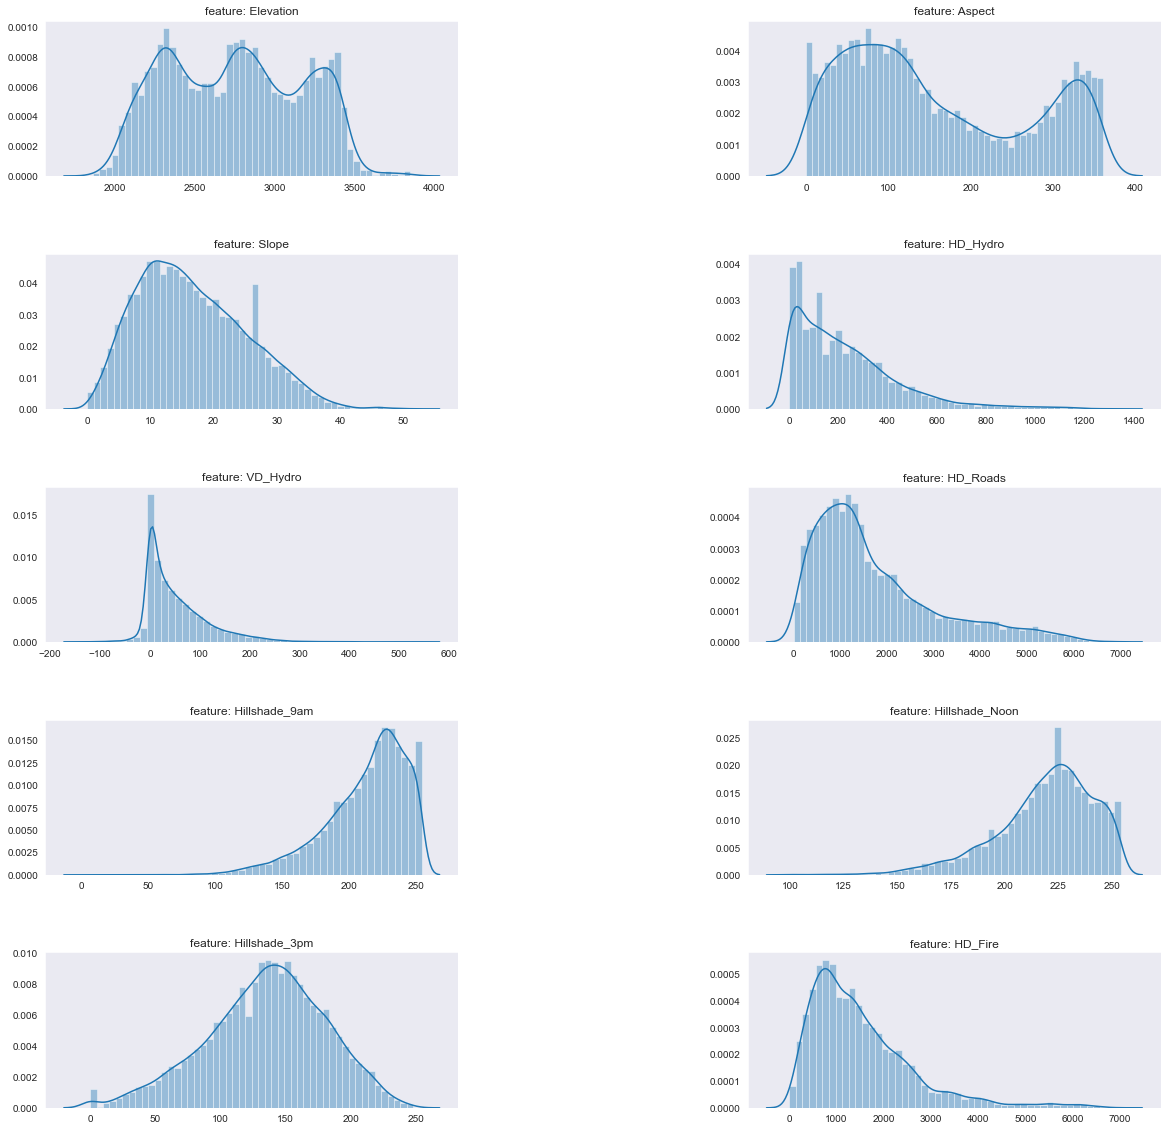

In [15]:
gs = gridspec.GridSpec(nrows=5, ncols=2)
gs.update(wspace=0.7, hspace=0.5)
plt.figure(figsize=(20,20))
for i, col in enumerate(df_forest[actual_features]):
    ax1 = plt.subplot(gs[i])
    sns.distplot(df_forest[col], bins=50)
    ax1.set_title('feature: ' + str(col))
    plt.xlabel('')
    plt.ylabel('')
plt.show()

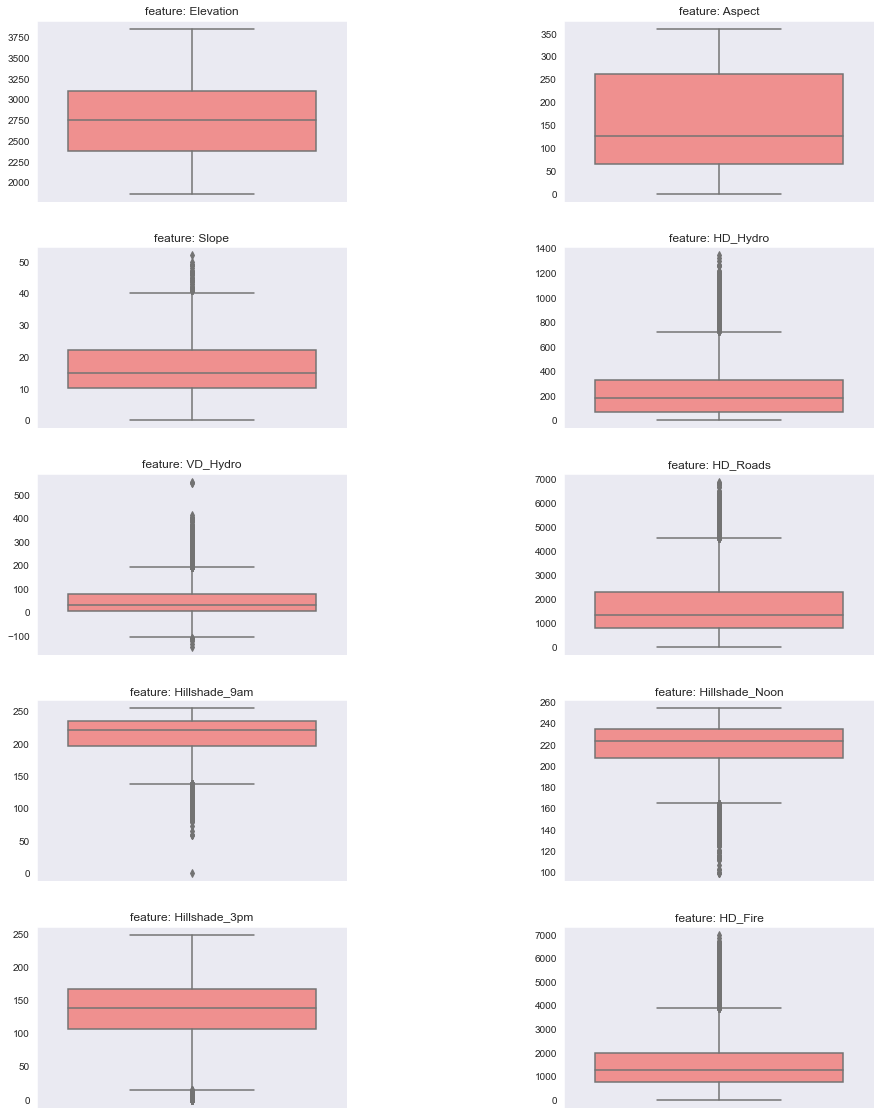

In [16]:
gs = gridspec.GridSpec(nrows=5, ncols=2)
gs.update(wspace=0.7, hspace=0.25)
plt.figure(figsize=(15,20))
for i, col in enumerate(df_forest[actual_features]):
    ax2 = plt.subplot(gs[i])
    sns.boxplot(y=df_forest[col], showfliers=True, palette="spring")
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('feature: ' + str(col))
plt.show()

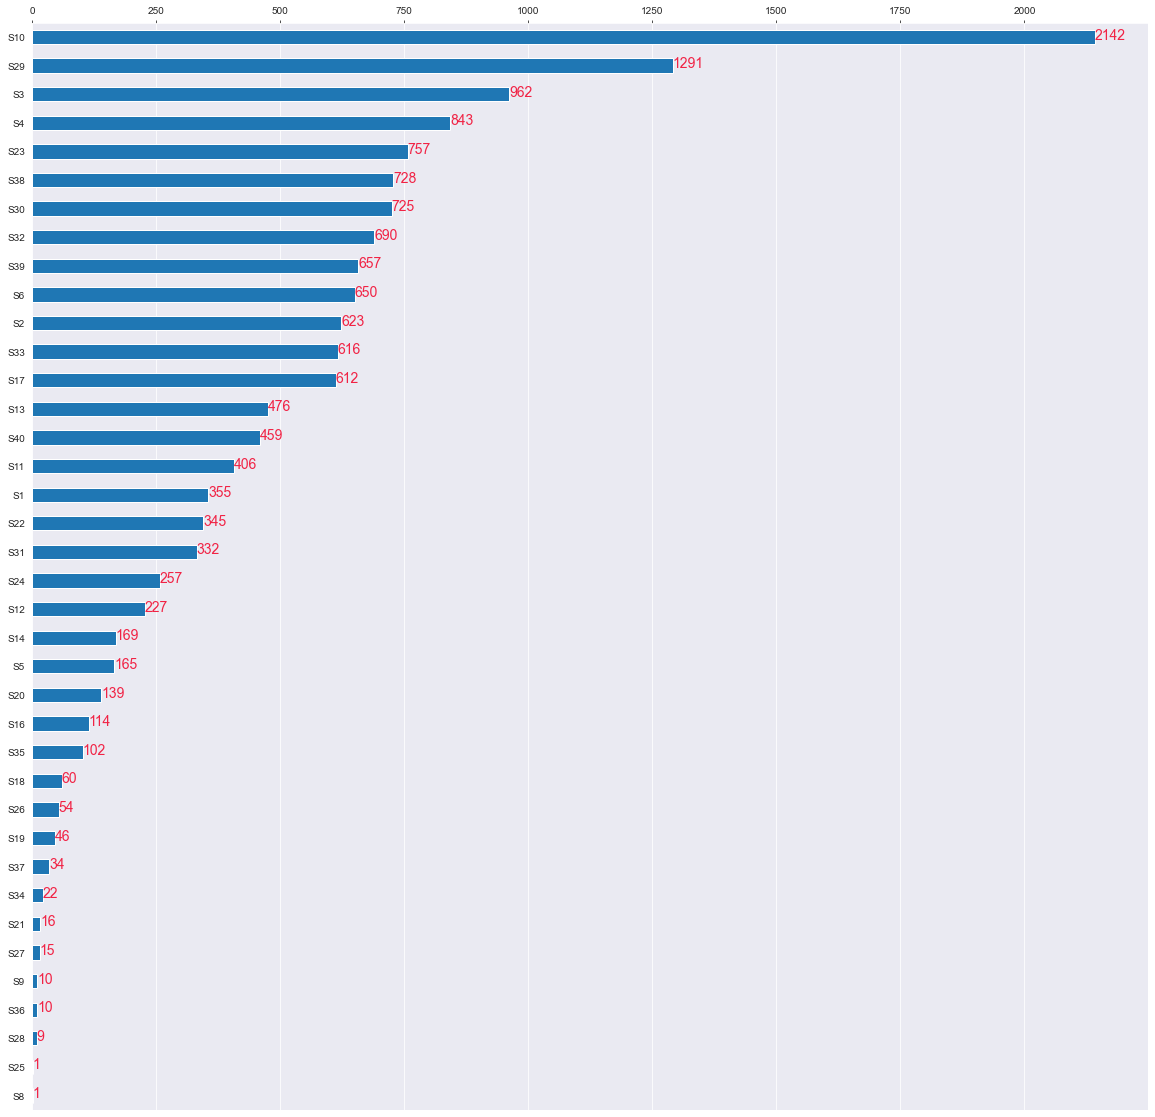

In [17]:
ax3 = df_forest[encoded_features_soil_type].idxmax(1).value_counts().sort_values(ascending=False).plot.barh(figsize=(20,20),position=0.5)
# set individual bar lables using above list
for i in ax3.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax3.text(i.get_width(), i.get_y()+.32,
            str(int(i.get_width())), fontsize=14,color='#F12345')
ax3.xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().xaxis.grid()
plt.show()

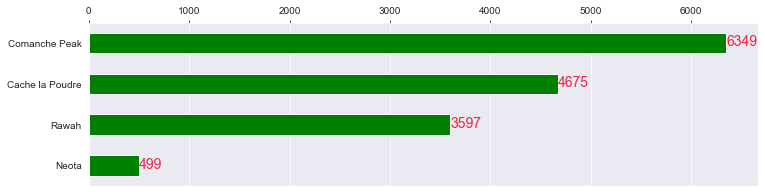

In [18]:
ax4 = df_forest[encoded_features_wilderness_area].idxmax(1).value_counts().sort_values(ascending=False).plot.barh(figsize=(12,3),position=0.5, color="green")
# set individual bar lables using above list
for i in ax4.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax4.text(i.get_width(), i.get_y()+.32,
            str(int(i.get_width())), fontsize=14,color='#F12345')
ax4.xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().xaxis.grid()
plt.show()

### EDA - Bivariate (Features Vs Label)

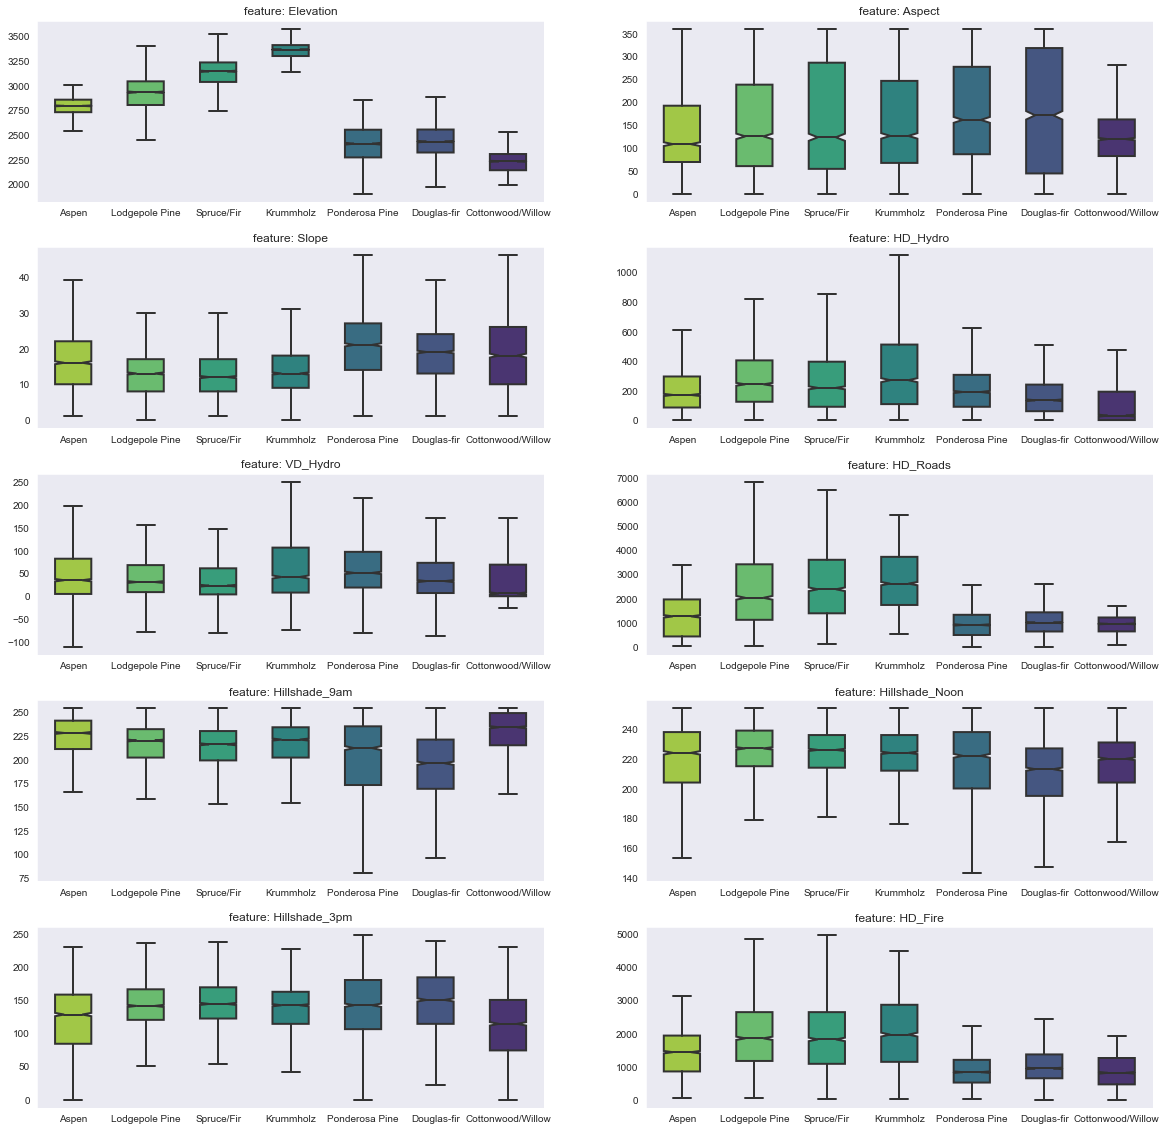

In [19]:
gs = gridspec.GridSpec(nrows=5, ncols=2)
gs.update(wspace=0.2, hspace=0.25)
plt.figure(figsize=(20,20))
for i, col in enumerate(df_forest[actual_features]):
    ax5 = plt.subplot(gs[i])
    sns.boxplot(x=df_forest[label],y=df_forest[col], showfliers=False, palette="viridis_r", notch=True,
                width=0.5, linewidth=2)
    ax5.set_title('feature: ' + str(col))
    ax5.set_xlabel('')
    ax5.set_ylabel('')
plt.show()

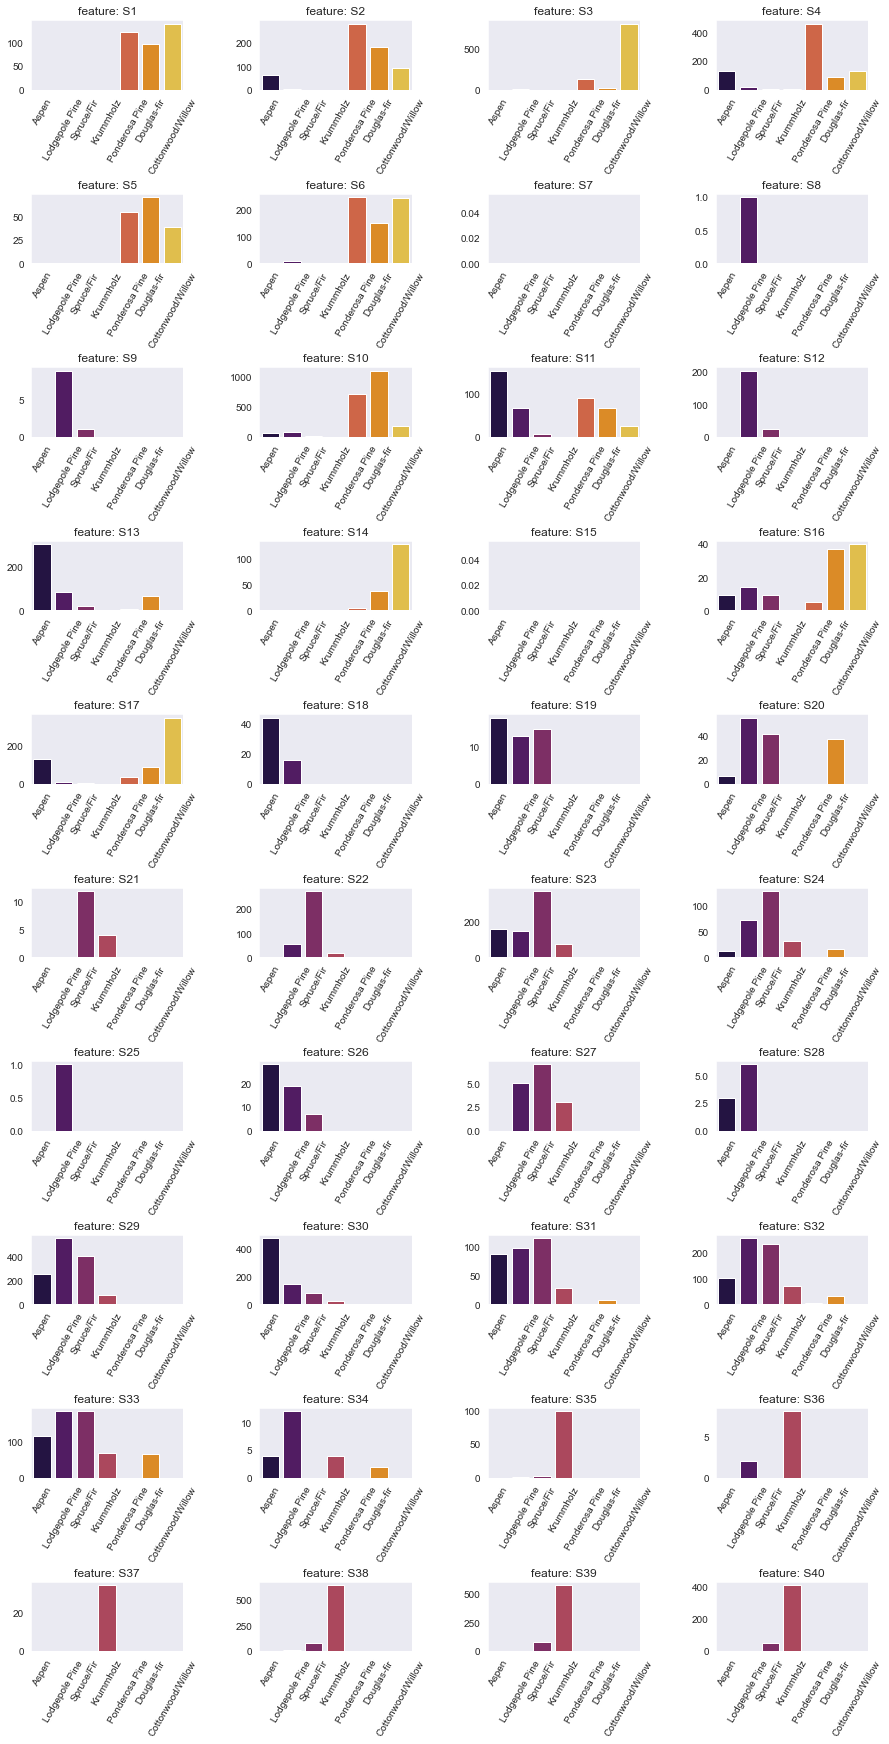

In [20]:
gs = gridspec.GridSpec(nrows=10, ncols=4)
gs.update(wspace=0.5, hspace=1.5)
plt.figure(figsize=(15,30))
for i, col in enumerate(df_forest[encoded_features_soil_type]):
    ax6 = plt.subplot(gs[i])
    sns.barplot(x=df_forest[label], y=df_forest[col], palette="inferno", ci=None, estimator=sum)
    ax6.set_title('feature: ' + str(col))
    ax6.set_xlabel('')
    plt.xticks(rotation=60)
    ax6.set_ylabel('')
    plt.ylim(0)
plt.show()

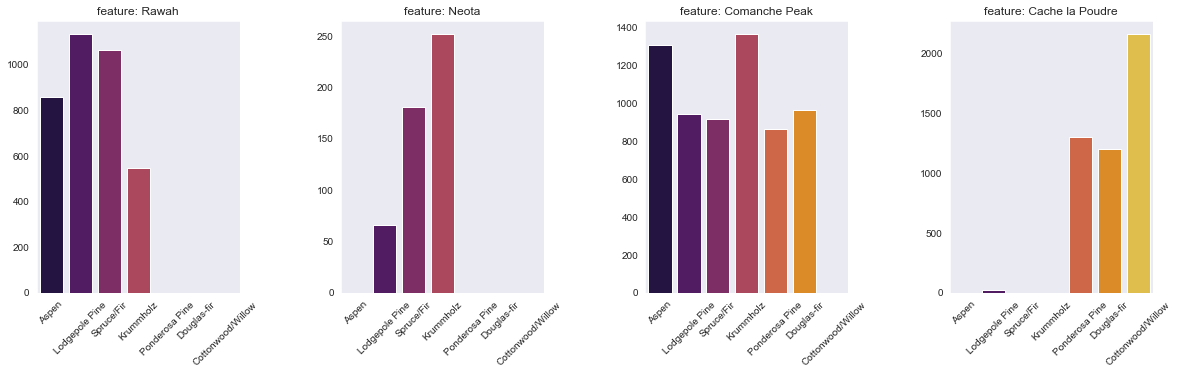

In [21]:
gs = gridspec.GridSpec(nrows=1, ncols=4)
gs.update(wspace=0.5, hspace=0.5)
plt.figure(figsize=(20,5))
for i, col in enumerate(df_forest[encoded_features_wilderness_area]):
    ax7 = plt.subplot(gs[i])
    sns.barplot(x=df_forest[label], y=df_forest[col], palette="inferno", ci=None, estimator=sum)
    ax7.set_title('feature: ' + str(col))
    ax7.set_xlabel('')
    plt.xticks(rotation=45)
    ax7.set_ylabel('')
    plt.ylim(0)
plt.show()

In [25]:
def identify_strong_corr(val):
    if (val < -0.6) & (val != 1.0) & (val != -1.0):
        color = 'pink'
    elif (val > 0.6) & (val != 1.0) & (val != -1.0):
        color = 'pink'
    else:
        color= 'white'
    return 'background-color: %s' % color

corr = df_forest[actual_features].corr()
corr.style.applymap(identify_strong_corr)

### EDA - Multivariate

##### As per the above correlation table, we can observe that the features correlated with each other with a min threshold of correlation coefficient as 0.3 are Slope - Elevation, Hillshade_9am - Aspect, Hillshade_Noon - Slope, Hillshade_3pm - Slope, Hillshade_9am - Hillshade_3pm

##### Hence, we will do the multivariate EDA via scatter plots only of these features - Elevation, Aspect, Slope, Hillshade_9am, Hillshade_Noon & Hillshade_3pm

In [22]:
lst_multivariate_features = ["Elevation", "Aspect", "Slope", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm","Cover_Type"]

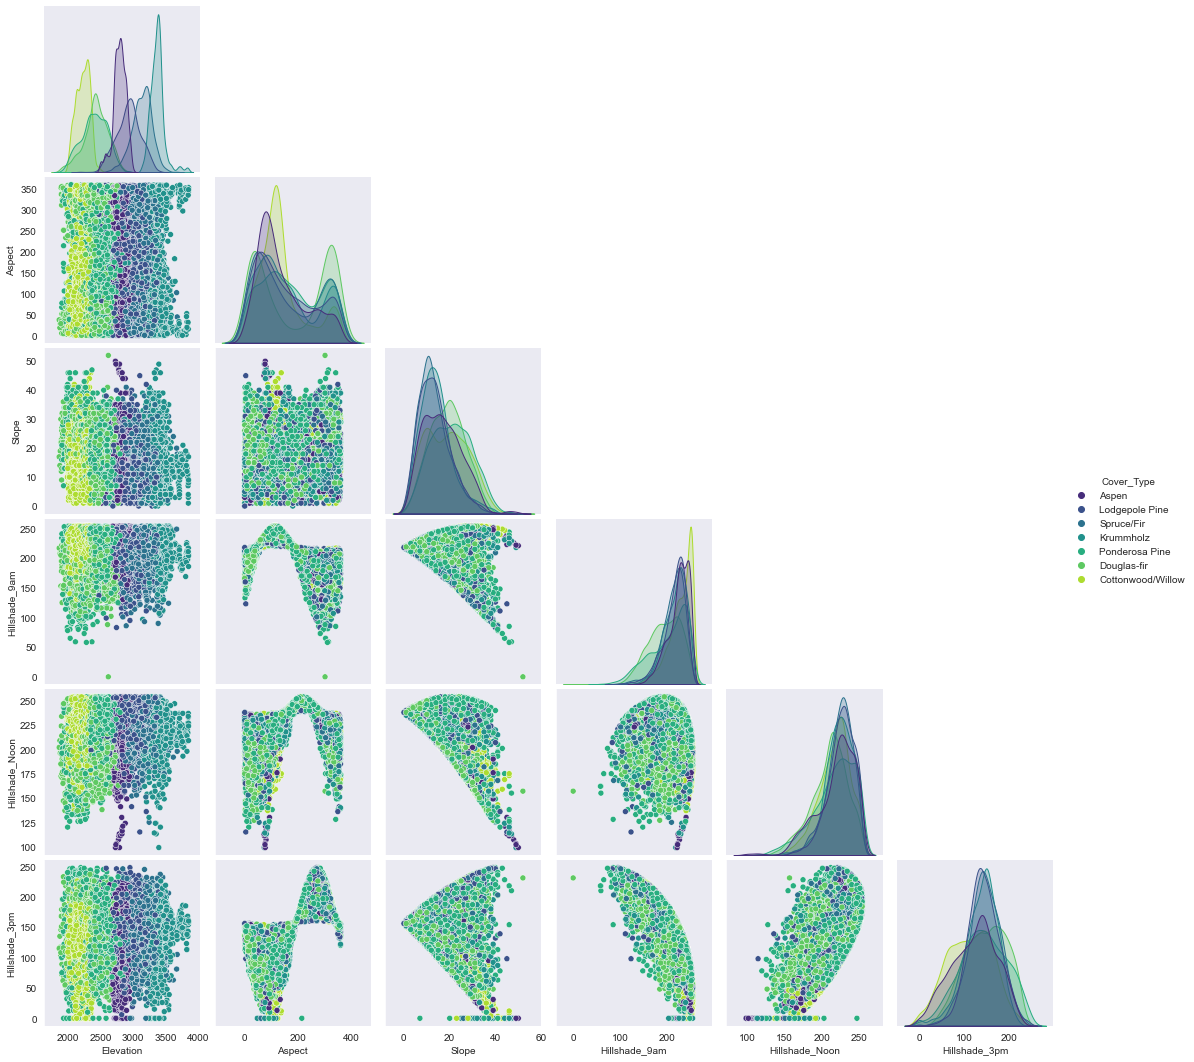

In [23]:
sns.pairplot(data=df_forest[lst_multivariate_features],hue=label,kind="scatter", corner=True, palette="viridis")

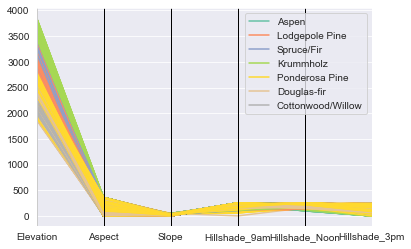

In [24]:
parallel_coordinates(df_forest[lst_multivariate_features],label,colormap=plt.get_cmap("Set2"))
plt.show()

### Plot a few 3d scatter plots and if possible a few fancy charts

In [29]:
dictColor = {"Aspen":"#D5D2D1","Lodgepole Pine":"#F8B581","Spruce/Fir":"#182A61","Krummholz":"#B53B03",
             "Ponderosa Pine":"#B9CBD5","Douglas-fir":"#E0CDAD","Cottonwood/Willow":"#3454DF"}

trace = go.Scatter3d(
    x = df_forest['Elevation'],
    y = df_forest['Hillshade_9am'],
    z = df_forest['Slope'],
    text = df_forest['Cover_Type'],
    mode = 'markers',
    marker = dict(color = list(dictColor[i] for i in list(df_forest['Cover_Type']))),
    hovertext = ['Cover Type: ' + str(ctype) for ctype in df_forest['Cover_Type']]
)
data = [trace]

layout = go.Layout(
    width = 800,
    height = 800,
    title = 'Cover Types and Its Dependency on Selected Features',
    scene = dict(
        xaxis = dict(
            title = 'Elevation',
            color = 'white',
            titlefont = dict(
                color = 'yellow'
            )
        ),
        yaxis = dict(
            title = 'Hillshade at 9 AM',
            color = 'white',
            titlefont = dict(
                color = 'yellow'
            )
        ),
        zaxis = dict(
            title = 'Slope',
            color = 'white',
            titlefont = dict(
                color = 'yellow'
            )
        ),
        bgcolor = '#141836'
    )
)

fig = go.Figure(
    data = data,
    layout = layout
)
offline.iplot(fig)

In [30]:
dictColor = {"Aspen":"#D5D2D1","Lodgepole Pine":"#F8B581","Spruce/Fir":"#182A61","Krummholz":"#B53B03",
             "Ponderosa Pine":"#B9CBD5","Douglas-fir":"#E0CDAD","Cottonwood/Willow":"#3454DF"}

trace = go.Scatter3d(
    x = df_forest['Hillshade_9am'],
    y = df_forest['Hillshade_Noon'],
    z = df_forest['Hillshade_3pm'],
    text = df_forest['Cover_Type'],
    mode = 'markers',
    marker = dict(color = list(dictColor[i] for i in list(df_forest['Cover_Type']))),
    hovertext = ['Cover Type: ' + str(ctype) for ctype in df_forest['Cover_Type']]
)
data = [trace]

layout = go.Layout(
    width = 800,
    height = 800,
    title = 'Cover Types and Its Dependency on Selected Features',
    scene = dict(
        xaxis = dict(
            title = 'Hillshade at 9 AM',
            color = 'white',
            titlefont = dict(
                color = 'yellow'
            )
        ),
        yaxis = dict(
            title = 'Hillshade at Noon',
            color = 'white',
            titlefont = dict(
                color = 'yellow'
            )
        ),
        zaxis = dict(
            title = 'Hillshade at 3 PM',
            color = 'white',
            titlefont = dict(
                color = 'yellow'
            )
        ),
        bgcolor = '#141836'
    )
)

fig = go.Figure(
    data = data,
    layout = layout
)
offline.iplot(fig)

### EDA - Label

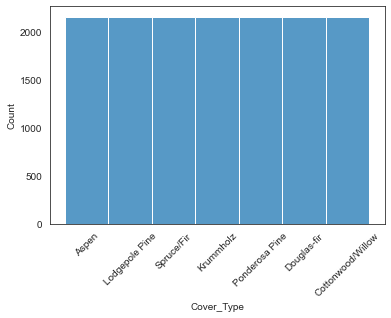

In [34]:
sns.histplot(df_forest[label])
plt.xticks(rotation=45)
plt.show()

##### There are no missing values and the label classes are perfectly balanced, however, all the visualiations in the output of the EDA exercise scream for the need of scaling, transformation, removing outliers, re-encoding, feature engineering and feature selection

## Data Preprocessing

### Identifying Missing & Erroneous Values

In [35]:
df_forest.isnull().any().sum()

0

In [29]:
df_forest.describe()

Elevation        Aspect         Slope      HD_Hydro      VD_Hydro  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587    227.195701     51.076521   
std      417.678187    110.085801      8.453927    210.075296     61.239406   
min     1863.000000      0.000000      0.000000      0.000000   -146.000000   
25%     2376.000000     65.000000     10.000000     67.000000      5.000000   
50%     2752.000000    126.000000     15.000000    180.000000     32.000000   
75%     3104.000000    261.000000     22.000000    330.000000     79.000000   
max     3849.000000    360.000000     52.000000   1343.000000    554.000000   

           HD_Roads  Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count  15120.000000   15120.000000    15120.000000   15120.000000   
mean    1714.023214     212.704299      218.965608     135.091997   
std     1325.066358      30.561287       22.801966      45.895189   
min        0.000000       0.000000       99.000000       0.000000   
25%      764.000000     196.000000      207.000000     106.000000   
50%     1316.000000     220.000000      223.000000     138.000000   
75%     2270.000000     235.000000      235.000000     167.000000   
max     6890.000000     254.000000      254.000000     248.000000   

            HD_Fire  ...           S31           S32           S33  \
count  15120.000000  ...  15120.000000  15120.000000  15120.000000   
mean    1511.147288  ...      0.021958      0.045635      0.040741   
std     1099.936493  ...      0.146550      0.208699      0.197696   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%      730.000000  ...      0.000000      0.000000      0.000000   
50%     1256.000000  ...      0.000000      0.000000      0.000000   
75%     1988.250000  ...      0.000000      0.000000      0.000000   
max     6993.000000  ...      1.000000      1.000000      1.000000   

                S34           S35           S36           S37           S38  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean       0.001455      0.006746      0.000661      0.002249      0.048148   
std        0.038118      0.081859      0.025710      0.047368      0.214086   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                S39           S40  
count  15120.000000  15120.000000  
mean       0.043452      0.030357  
std        0.203880      0.171574  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000  

[8 rows x 54 columns]

##### There are no missing values, however, there are two features having erroneous values - VD_Hydro & Aspect.

- VD_Hydro: 
##### For the purpose of this exercise we would be assuming that the forest cover type is independent of the elevation differences between the water body and the ground.
##### Also, since we can observe that only a few DISTANCE values in the entire dataset are negative, we can call these as an aberration or an error in data recording
##### Hence, we would be taking distances only as values and not as vectors. For accomplishing this, we would be taking the absolute value of distances and disregarding the +/- signs


- Aspect:
##### Aspect is given in azimuth degrees, that means angle in degrees as compared to a grographic direction, mostly North. Here we have one value represented in two forms (0 and 360) which are same. Hence, we would need to replace 360 with 0 or 0 with 360.
##### We can have two approaches here depending on the relative density of values -
###### If the number of such values are high as compared to the entire dataset, then we can use imputation algorithm and measure/compare scores.
###### If the number of such values are too low as compared to the entire dataset, we can safely assume that there would be no impact and replace 0 with 360 or 360 with 0.

In [30]:
df_forest["VD_Hydro"] = np.abs(df_forest["VD_Hydro"])

In [31]:
print("Count of Instances with Apsect = 0: ",len(df_forest[df_forest["Aspect"] == 0]))
print("Count of Instances with Apsect = 360: ",len(df_forest[df_forest["Aspect"] == 360]))

Count of Instances with Apsect = 0:  110
Count of Instances with Apsect = 360:  2


In [32]:
df_forest["Aspect"].replace(to_replace=360,value=0,inplace=True)

In [33]:
df_forest[df_forest["Aspect"] == 360]["Aspect"]

Series([], Name: Aspect, dtype: int64)

#### Feature Engineering

#### Let us start with checking out the existing features in the dataset

| Columns | Decription     | Unit |
|---------|-----------------|------------|
|   Elevation  |Elevation in meters|meters|
| Aspect   |Aspect in degrees azimuth|degrees azimuth|
|Slope    |Slope in degrees|degrees|
|Horizontal_Distance_To_Hydrology|Horz Dist to nearest surface water features|meters|
|Vertical_Distance_To_Hydrology   |Vert Dist to nearest surface water features|meters|
|Horizontal_Distance_To_Roadways     |Horz Dist to nearest roadway|meters|
|Hillshade_9am       |Hillshade index at 9am, summer solstice|0 to 255 index|
|Hillshade_Noon|Hillshade index at noon, summer solstice|0 to 255 index|
|Hillshade_3pm|Hillshade index at 3pm, summer solstice|0 to 255 index|
|Horizontal_Distance_To_Fire_Points|Horz Dist to nearest wildfire ignition points|meters|
|Wilderness_AreaX (4 Binary Features) |Wilderness area designation|binary, 0/1|
|Soil_TypeX (40 Binary Features)|Soil Type designation|binary, 0/1|
|Cover_TypeX (7 Classes)|Forest Cover Type designation|1,2,3,4,5,6,7|

#### We can start Feature Engineering exercise by getting the features in similar units

#### Assuming that the Aspect is measured from the North, we can infer:
##### 90 Degrees Correspond to East, 180 degrees correspond to South and 270 degrees correspond to West.
#### Using this information, we can identify the geographical direction

In [34]:
def get_direction(angle):
    if angle == 0:
        return "N"
    elif 0<angle<90:
        return "NE"
    elif angle == 90:
        return "E"
    elif 90<angle<180:
        return "SE"
    elif angle == 180:
        return "S"
    elif 180<angle<270:
        return "SW"
    elif angle == 270:
        return "W"
    else:
        return "NW"

In [35]:
df_forest["Aspect_direction"] = df_forest["Aspect"].apply(get_direction)
actual_features.append("Aspect_direction")

In [36]:
df_forest["Aspect_direction"].unique()

array(['NE', 'SE', 'SW', 'N', 'NW', 'E', 'S', 'W'], dtype=object)

#### We can observe that the units of the features are not of same type, so let us try to get the features in the same unit

#### For this, let us start with Aspect and Slope by taking their Cosine values as measure of distance

In [37]:
# np.cos takes in radians as input but we have values in degrees so we first convert degrees to radians and then take cosine
df_forest["Slope"] = np.cos(np.radians(df_forest["Slope"]))
df_forest["Aspect"] = np.cos(np.radians(df_forest["Aspect"]))

#### As we observed above that the VD_Hydro was not highly correlated with the other features or with the Cover Type, hence we can take a Pythogorean measure of distance from the point of observation to the water body and we can call it as Diagonal Distance to Hydrology

In [38]:
df_forest["DD_Hydro"] = np.sqrt(df_forest["HD_Hydro"]*df_forest["HD_Hydro"] + df_forest["VD_Hydro"]*df_forest["VD_Hydro"])
actual_features.append("DD_Hydro")

In [39]:
df_forest.drop(["HD_Hydro", "VD_Hydro"], axis=1, inplace=True)
actual_features.remove("HD_Hydro")
actual_features.remove("VD_Hydro")

#### Coming to the Hillshade values, let us try to identify the change in illumination and its impact on the irradiance and reflection from 9 AM to Noon to 3 PM

#### For this, we can introduce two features - Mean of the Hillshade index across the three times and the direction (Increase-Increase, Increase-Decrease, Decrease-Increase & Decrease-Decrease or II, ID, DI, DD)

In [40]:
def get_flow_hillshade(val1, val2, val3):
    if val1<val2<val3:
        return "IC-IC"
    elif val1<val2>val3:
        return "IC-DC"
    elif val1>val2<val3:
        return "DC-IC"
    elif val1>val2>val3:
        return "DC-DC"
    elif val1==val2==val3:
        return "NC-NC"
    elif val1==val2<val3:
        return "NC-IC"
    elif val1==val2>val3:
        return "NC-DC"
    elif val1<val2==val3:
        return "IC-NC"
    elif val1>val2==val3:
        return "DC-NC"

In [41]:
df_forest["Avg_Hillshade"] = (df_forest["Hillshade_9am"] + df_forest["Hillshade_Noon"] + df_forest["Hillshade_3pm"])/3
df_forest["Flow_Hillshade"] = df_forest.apply(lambda x: get_flow_hillshade(x.Hillshade_9am, x.Hillshade_Noon, x.Hillshade_3pm), axis=1)
actual_features.append("Avg_Hillshade")
actual_features.append("Flow_Hillshade")
df_forest.drop(["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"],axis=1,inplace=True)
actual_features.remove("Hillshade_9am")
actual_features.remove("Hillshade_Noon")
actual_features.remove("Hillshade_3pm")

In [42]:
df_forest.head()

Elevation    Aspect     Slope  HD_Roads  HD_Fire  Rawah  Neota  \
0       2596  0.629320  0.998630       510     6279      1      0   
1       2590  0.559193  0.999391       390     6225      1      0   
2       2804 -0.754710  0.987688      3180     6121      1      0   
3       2785 -0.906308  0.951057      3090     6211      1      0   
4       2595  0.707107  0.999391       391     6172      1      0   

   Comanche Peak  Cache la Poudre  S1  ...  S36  S37  S38  S39  S40  \
0              0                0   0  ...    0    0    0    0    0   
1              0                0   0  ...    0    0    0    0    0   
2              0                0   0  ...    0    0    0    0    0   
3              0                0   0  ...    0    0    0    0    0   
4              0                0   0  ...    0    0    0    0    0   

       Cover_Type  Aspect_direction    DD_Hydro  Avg_Hillshade  Flow_Hillshade  
0           Aspen                NE  258.000000     200.333333           IC-DC  
1           Aspen                NE  212.084889     202.000000           IC-DC  
2  Lodgepole Pine                SE  275.769832     202.333333           IC-DC  
3  Lodgepole Pine                SE  269.235956     199.333333           NC-DC  
4           Aspen                NE  153.003268     201.333333           IC-DC  

[5 rows x 54 columns]

In [43]:
df_forest["WA_Type"] = df_forest[encoded_features_wilderness_area].idxmax(1)
df_forest[df_forest.loc[:,"Rawah"] == 1]["WA_Type"] == "Rawah"
df_forest[df_forest.loc[:,"Neota"] == 1]["WA_Type"] == "Neota"
df_forest[df_forest.loc[:,"Comanche Peak"] == 1]["WA_Type"] == "Comanche Peak"
df_forest[df_forest.loc[:,"Cache la Poudre"] == 1]["WA_Type"] == "Cache la Poudre"
actual_features.append("WA_Type")

In [44]:
df_forest.columns

Index(['Elevation', 'Aspect', 'Slope', 'HD_Roads', 'HD_Fire', 'Rawah', 'Neota',
       'Comanche Peak', 'Cache la Poudre', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6',
       'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16',
       'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26',
       'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36',
       'S37', 'S38', 'S39', 'S40', 'Cover_Type', 'Aspect_direction',
       'DD_Hydro', 'Avg_Hillshade', 'Flow_Hillshade', 'WA_Type'],
      dtype='object')

In [45]:
df_soiltypes = pd.read_excel("Soil Types.xlsx", header=None, names=["Details"])

lstIndex, lstSoilTypes = [],[]

for x in df_soiltypes["Details"].str.split():
    lstIndex.append("S" + str(x[0]))
    lstSoilTypes.append(x[-1])
df_soiltypes["Soil_Index"], df_soiltypes["Ground_Type"] = pd.Series(lstIndex), pd.Series(lstSoilTypes)
df_soiltypes["Ground_Type"] = df_soiltypes["Ground_Type"].str.replace(".","").str.replace("family","NA").str.replace("complex","NA").str.replace("Survey","NA")
df_soiltypes.drop(["Details"],axis=1,inplace=True)

In [46]:
df_forest["Soil_Index"] = df_forest[encoded_features_soil_type].idxmax(1)
df_forest = pd.merge(left=df_soiltypes, right=df_forest, on="Soil_Index")
df_forest.drop("Soil_Index", axis=1, inplace=True)
actual_features.append("Ground_Type")

In [47]:
df_forest["Soil_Type"] = df_forest[encoded_features_soil_type].idxmax(1)

In [48]:
df_forest.drop(encoded_features_soil_type,axis=1,inplace=True)
df_forest.drop(encoded_features_wilderness_area,axis=1,inplace=True)

In [49]:
numeric_features = ["Elevation","Aspect","Slope","HD_Roads","HD_Fire","DD_Hydro","Avg_Hillshade"]
cat_features = ["Ground_Type","Aspect_direction","Flow_Hillshade","WA_Type","Soil_Type"]

In [50]:
df_forest_with_dummies = pd.get_dummies(df_forest,columns=cat_features,drop_first=True)
df_forest_with_dummies.head()

Elevation    Aspect     Slope  HD_Roads  HD_Fire      Cover_Type  \
0       2173  0.642788  0.882948       212      552  Ponderosa Pine   
1       2161 -0.390731  0.848048       524      390  Ponderosa Pine   
2       2110  0.587785  0.906308       390      466  Ponderosa Pine   
3       2206  0.422618  0.838671       201      361  Ponderosa Pine   
4       2132  0.292372  0.891007       408      488  Ponderosa Pine   

     DD_Hydro  Avg_Hillshade  Ground_Type_bouldery  Ground_Type_rubbly  ...  \
0  159.298462     150.000000                     0                   0  ...   
1  479.508081     158.666667                     0                   0  ...   
2  373.448792     157.666667                     0                   0  ...   
3  254.629142     138.333333                     0                   0  ...   
4  403.495973     157.000000                     0                   0  ...   

   Soil_Type_S36  Soil_Type_S37  Soil_Type_S38  Soil_Type_S39  Soil_Type_S4  \
0              0              0              0              0             0   
1              0              0              0              0             0   
2              0              0              0              0             0   
3              0              0              0              0             0   
4              0              0              0              0             0   

   Soil_Type_S40  Soil_Type_S5  Soil_Type_S6  Soil_Type_S8  Soil_Type_S9  
0              0             0             0             0             0  
1              0             0             0             0             0  
2              0             0             0             0             0  
3              0             0             0             0             0  
4              0             0             0             0             0  

[5 rows x 62 columns]

#### Now that we have completed our Feature Engineering part, we need to move towards the pre-processing items which would require the dataset to be split into train and test sets

### Data Pre-Processing

### Split the dataset into train and test sets

In [51]:
df_forest_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 0 to 15119
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Elevation              15120 non-null  int64  
 1   Aspect                 15120 non-null  float64
 2   Slope                  15120 non-null  float64
 3   HD_Roads               15120 non-null  int64  
 4   HD_Fire                15120 non-null  int64  
 5   Cover_Type             15120 non-null  object 
 6   DD_Hydro               15120 non-null  float64
 7   Avg_Hillshade          15120 non-null  float64
 8   Ground_Type_bouldery   15120 non-null  uint8  
 9   Ground_Type_rubbly     15120 non-null  uint8  
 10  Ground_Type_stony      15120 non-null  uint8  
 11  Aspect_direction_N     15120 non-null  uint8  
 12  Aspect_direction_NE    15120 non-null  uint8  
 13  Aspect_direction_NW    15120 non-null  uint8  
 14  Aspect_direction_S     15120 non-null  uint8  
 15  As

In [52]:
df_forest_with_dummies["Cover_Type"] = df_forest_with_dummies["Cover_Type"].map({"Spruce/Fir":1,"Lodgepole Pine":2,
                                                                               "Ponderosa Pine":3,"Cottonwood/Willow":4,
                                                                               "Aspen":5,"Douglas-fir":6,"Krummholz":7})

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df_forest_with_dummies.drop(label,axis=1).values, df_forest[label].values,
                                                    test_size=0.3, random_state=0)

In [55]:
print("X train Shape: ", X_train.shape)
print("X test Shape: ", X_test.shape)
print("y train Shape: ", y_train.shape)
print("Y test Shape: ", y_test.shape)

X train Shape:  (10584, 61)
X test Shape:  (4536, 61)
y train Shape:  (10584,)
Y test Shape:  (4536,)


#### From here on we would fit & transform/predict the models on train datasets, however we would only do transform/predict on test sets

### Check the dataset for Class Imbalance

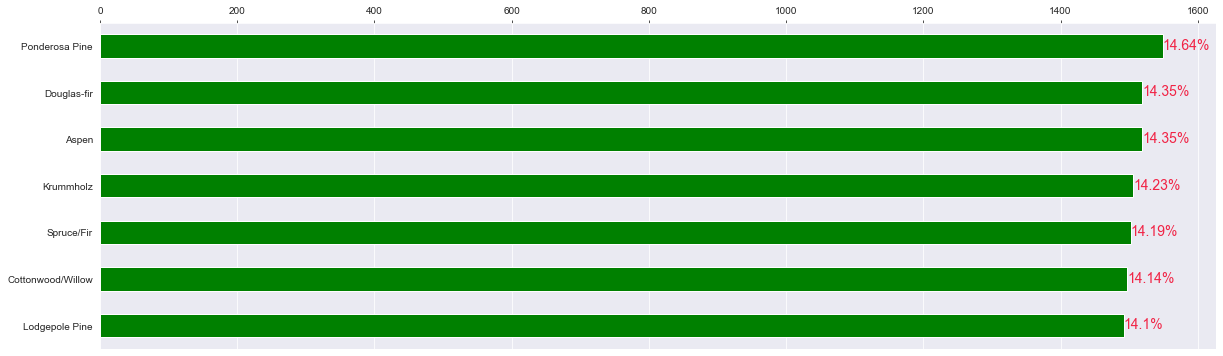

In [56]:
ax8 = pd.Series(y_train).value_counts().sort_values(ascending=False).plot.barh(figsize=(20,6),position=0.5, color="green")
# set individual bar lables using above list
for i in ax8.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax8.text(i.get_width(), i.get_y()+.32,
            str(round(i.get_width()*100/len(y_train),2))+"%", fontsize=14,color='#F12345')
ax8.xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().xaxis.grid()
plt.show()

##### The dataset looks to be balanced

### Check for Outliers

In [57]:
from sklearn.ensemble import IsolationForest

In [58]:
model_outliers_isolation_forest = IsolationForest(max_samples=100, random_state=0, contamination='auto')
model_outliers_isolation_forest.fit(X_train, y_train)
outlier_preds_train = model_outliers_isolation_forest.predict(X_train)
mask = outlier_preds_train != -1
X_train_wo_outliers = X_train[mask, :]
y_train_wo_outliers = y_train[mask]
print("Before Handling Outliers: ",pd.DataFrame(X_train).shape,",", len(y_train))
print("After Handling Outliers: ",pd.DataFrame(X_train_wo_outliers).shape, ",", len(y_train_wo_outliers))

Before Handling Outliers:  (10584, 61) , 10584
After Handling Outliers:  (10560, 61) , 10560


In [59]:
outlier_preds_test = model_outliers_isolation_forest.predict(X_test)
mask = outlier_preds_test != -1
X_test_wo_outliers = X_test[mask, :]
y_test_wo_outliers = y_test[mask]
print("Before Handling Outliers: ",pd.DataFrame(X_test).shape,",", len(y_test))
print("After Handling Outliers: ",pd.DataFrame(X_test_wo_outliers).shape, ",", len(y_test_wo_outliers))

Before Handling Outliers:  (4536, 61) , 4536
After Handling Outliers:  (4530, 61) , 4530


### Scale the dataset

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

In [61]:
model_scaler = RobustScaler()
X_train_wo_outliers_scaled = model_scaler.fit_transform(X_train_wo_outliers)
X_test_wo_outliers_scaled = model_scaler.transform(X_test_wo_outliers)

### Feature Selection

#### Let us drop the features which have zero standard deviation

In [62]:
drop_cols=[]
for cols in pd.DataFrame(X_train_wo_outliers_scaled).columns:
    if pd.DataFrame(X_train_wo_outliers_scaled)[cols].std()==0:
        drop_cols.append(cols)
print("Number of constant columns to be dropped: ", len(drop_cols))
print(drop_cols)
pd.DataFrame(X_train_wo_outliers_scaled).drop(drop_cols,axis=1, inplace = True)

Number of constant columns to be dropped:  2
[39, 59]


In [63]:
pd.DataFrame(X_train_wo_outliers_scaled).drop(drop_cols,axis=1, inplace = True)

#### Let us try PCA as a method for Feature Selection

In [64]:
from sklearn.decomposition import PCA

In [65]:
model_pca = PCA(0.95).fit(X_train_wo_outliers_scaled)

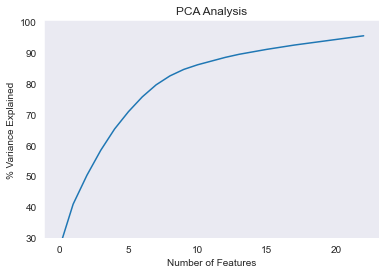

In [66]:
var=np.cumsum(np.round(model_pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [67]:
print('%d components explain 95%% of the variation in data' % model_pca.n_components_)

23 components explain 95% of the variation in data


In [68]:
model_pca_post_knee_plot = PCA(n_components=model_pca.n_components_, random_state = 0)
model_pca_post_knee_plot.fit(X_train_wo_outliers_scaled)
X_train_wo_outliers_scaled_post_PCA = model_pca_post_knee_plot.transform(X_train_wo_outliers_scaled)
print(X_train_wo_outliers_scaled_post_PCA.shape)

(10560, 23)


In [69]:
X_test_wo_outliers_scaled_post_PCA = model_pca_post_knee_plot.transform(X_test_wo_outliers_scaled)
print(X_test_wo_outliers_scaled_post_PCA.shape)

(4530, 23)


### Machine Learning

In [70]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

#### Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
model_logreg = LogisticRegression()
model_logreg.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_rf = model_logreg.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_test_rf = model_logreg.predict(X_test_wo_outliers_scaled_post_PCA)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_rf))
print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_rf))

Accuracy Score for Training Set:  0.6930871212121212
Accuracy Score for Testing Set:  0.6907284768211921


#### Decision Trees

In [73]:
from sklearn import tree

In [74]:
model_dectree = tree.DecisionTreeClassifier(random_state=0)
model_dectree.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_dt = model_dectree.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_test_dt = model_dectree.predict(X_test_wo_outliers_scaled_post_PCA)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_dt))
print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_dt))

Accuracy Score for Training Set:  1.0
Accuracy Score for Testing Set:  0.6993377483443709


#### Let us try to tune the Decision Tree Model Manually

In [75]:
model_dectree_manual_tune = tree.DecisionTreeClassifier(random_state=0,max_depth=30,max_features=None,criterion='entropy')
model_dectree_manual_tune.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_dt_manual_tune = model_dectree_manual_tune.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_test_dt_manual_tune = model_dectree_manual_tune.predict(X_test_wo_outliers_scaled_post_PCA)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_dt_manual_tune))
print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_dt_manual_tune))

Accuracy Score for Training Set:  1.0
Accuracy Score for Testing Set:  0.7057395143487859


#### Let us try to tune the Decision Tree Model using Grid Search

In [76]:
# from sklearn.model_selection import GridSearchCV

In [77]:
# tree_params = [{'criterion':['gini','entropy'],'max_depth': range(2,60),
#                              'max_features': ['sqrt', 'log2', None] }]

In [78]:
# model_dectree_grid_tune = tree.DecisionTreeClassifier(random_state=0)
# model_grid_search = GridSearchCV(model_dectree_grid_tune,tree_params, cv=5,scoring='accuracy')
# model_grid_search.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
# y_pred_train_dt_grid_tune = model_grid_search.best_estimator_.predict(X_train_wo_outliers_scaled_post_PCA)
# y_pred_test_dt_grid_tune = model_grid_search.best_estimator_.predict(X_test_wo_outliers_scaled_post_PCA)
# print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_dt_grid_tune))
# print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_dt_grid_tune))

In [79]:
# model_grid_search.best_params_

#### Random Forest Classifier

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
model_rforest = RandomForestClassifier(random_state=0)
model_rforest.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_rf = model_rforest.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_test_rf = model_rforest.predict(X_test_wo_outliers_scaled_post_PCA)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_rf))
print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_rf))

Accuracy Score for Training Set:  1.0
Accuracy Score for Testing Set:  0.8052980132450331


#### Let us try to tune the Random Forest Model Manually

In [82]:
model_rforest_manual_tune = RandomForestClassifier(random_state=0,n_estimators=400,max_features="sqrt",min_samples_split=7,
                                                   min_samples_leaf=3,bootstrap=False,criterion="entropy", max_depth=30)
model_rforest_manual_tune.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_rf_manual_tune = model_rforest_manual_tune.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_test_rf_manual_tune = model_rforest_manual_tune.predict(X_test_wo_outliers_scaled_post_PCA)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_rf_manual_tune))
print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_rf_manual_tune))

Accuracy Score for Training Set:  0.9977272727272727
Accuracy Score for Testing Set:  0.8099337748344371


In [83]:
model_rforest_manual_tune.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=30,
                       max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=7, n_estimators=400, random_state=0)>

#### Let us try to tune the Random Forest Model using Randomized Search

In [84]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint as sp_randint

In [85]:
# param_dist = {"max_depth": range(25,30),
#               "min_samples_split": range(6,11),
#               "min_samples_leaf": range(1,5),
#               "bootstrap": [True, False],
#               "n_estimators": [400, 800],
#               "criterion" : ["gini", "entropy"],
#               'max_features': ['sqrt', 'log2', None]
#              }
# n_iter_search = 100

In [86]:
# model_rforest_random_tune = RandomForestClassifier(random_state=0)
# model_random_search_rforest = RandomizedSearchCV(model_rforest_random_tune,param_distributions=param_dist,n_iter=n_iter_search,
#                                                  n_jobs=-1)
# model_random_search_rforest.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
# y_pred_train_rf_random_tune = model_random_search_rforest.best_estimator_.predict(X_train_wo_outliers_scaled_post_PCA)
# y_pred_test_rf_random_tune = model_random_search_rforest.best_estimator_.predict(X_test_wo_outliers_scaled_post_PCA)
# print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_rf_random_tune))
# print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_rf_random_tune))

In [87]:
# model_random_search_rforest.best_params_

#### Gaussian Naive Bayes Classifier

In [88]:
from sklearn.naive_bayes import GaussianNB

In [89]:
model_gnb = GaussianNB()
model_gnb.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_gnb = model_gnb.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_test_gnb = model_gnb.predict(X_test_wo_outliers_scaled_post_PCA)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_gnb))
print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_gnb))

Accuracy Score for Training Set:  0.5669507575757575
Accuracy Score for Testing Set:  0.5838852097130243


#### K Nearest Neighbour Classifier

In [90]:
from sklearn.neighbors import KNeighborsClassifier

In [91]:
model_knn = KNeighborsClassifier(n_neighbors=27, metric='euclidean')
model_knn.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_knn = model_knn.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_test_knn = model_knn.predict(X_test_wo_outliers_scaled_post_PCA)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_knn))
print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_knn))

Accuracy Score for Training Set:  0.7138257575757576
Accuracy Score for Testing Set:  0.6995584988962472


#### Tuning KNN Classifier Model with Random Search

In [92]:
from sklearn.model_selection import RandomizedSearchCV

In [96]:
param_dist = {"n_neighbors": range(5,9),
              "p": range(1,3),
              "metric": ["minkowski","euclidean","chebyshev"]
             }
n_iter_search = 100

In [97]:
model_knn_random_tune = KNeighborsClassifier()
model_random_tune_knn = RandomizedSearchCV(model_knn_random_tune,param_distributions=param_dist,n_iter=n_iter_search,
                                                 n_jobs=-1)
model_random_tune_knn.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_knn_random_tune = model_random_tune_knn.best_estimator_.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_test_knn_random_tune = model_random_tune_knn.best_estimator_.predict(X_test_wo_outliers_scaled_post_PCA)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_wo_outliers,y_pred_train_knn_random_tune))
print("Accuracy Score for Testing Set: ", accuracy_score(y_test_wo_outliers,y_pred_test_knn_random_tune))

Accuracy Score for Training Set:  0.8272727272727273
Accuracy Score for Testing Set:  0.7439293598233996


In [95]:
model_random_tune_knn.best_params_

{'p': 1, 'n_neighbors': 11, 'metric': 'minkowski'}

In [109]:
repr(f1_score_dectree)

'0.6997873464486475'